# Build a neural network for pricing European Basket options using the data generated

In [186]:
# libraries
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras import regularizers
from keras.callbacks import EarlyStopping

In [ ]:
epochs = 100
vs = 0.2 # validation_split
bs = 32 # batch_size
n = 100 # iteration to plot

### Load the data:

In [187]:
df = pd.read_csv('Basket_pricing_data.csv')

In [188]:
df.head()

,Time_to_maturity,Volatility,Rate,Prices,Strikes,Basket_Price
0,0.653711,0.312417,0.027366,97.971978,115.487802,4.617228
1,0.553308,0.226359,0.035768,90.747605,142.051180,0.032997
2,0.422998,0.850931,0.055041,92.668292,82.093287,25.696106
3,0.721452,0.684244,0.021393,92.337340,98.394511,19.428791
4,0.488079,0.520385,0.075003,95.283133,82.584249,21.935407


### Split the data:

In [189]:
def split_data(data, label, test_size=0.3):
    """           
    Parameters
    ----------

    data : pd.Dataframe
          The simulated data.
    label : str
          Name of the label column.
    test_size : float
          The proportion of the dataset in the test split.
    
    """
    # split the data into features and labels
    X = data.drop([label], axis=1)
    y = data[label]

    # split the data to training and testing
    X_train, X_test, y_train, y_test =\
                 train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

In [190]:
# split the data
X_train, X_test, y_train, y_test = split_data(df, 'Basket_Price', 0.2)

In [191]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 5), (2000, 5), (8000,), (2000,))

### Build the model:

To build the model, we use the sequential API of keras. 

* It is composed of Dense layers.
* The output layer is a Dense layer with 1 neuron as we are predicting a numerical value (regression problem) and a 'relu' activation function since the Price option needs to be at least 0.
* For the loss function, we use Mean squared error (MSE). This finds the average squared difference between the predicted value and the true value.
* We tried adding dropout and normalization layers, but that didn't improve the performance of the model.

In [192]:
def build_model():
    """
    compiles and returns a Keras model
    """
    model = Sequential()

    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='relu'))

    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return(model)

To train the model, we set 100 iterations with batch size = 32.

In [193]:
# fit the model
model = build_model()
history = model.fit(X_train, y_train, epochs=epochs, validation_split=vs, batch_size=bs)

Epoch 1/100
200/200 [==============================] - 0s 1ms/step - loss: 87.7882 - mse: 87.7882 - val_loss: 54.4404 - val_mse: 54.4404
Epoch 2/100
200/200 [==============================] - 0s 975us/step - loss: 53.5577 - mse: 53.5577 - val_loss: 50.6892 - val_mse: 50.6892
Epoch 3/100
200/200 [==============================] - 0s 2ms/step - loss: 49.2021 - mse: 49.2021 - val_loss: 54.0057 - val_mse: 54.0057
Epoch 4/100
200/200 [==============================] - 0s 1ms/step - loss: 45.3544 - mse: 45.3544 - val_loss: 42.1335 - val_mse: 42.1335
Epoch 5/100
200/200 [==============================] - 0s 898us/step - loss: 37.6770 - mse: 37.6770 - val_loss: 33.8706 - val_mse: 33.8706
Epoch 6/100
200/200 [==============================] - 0s 1ms/step - loss: 28.9490 - mse: 28.9490 - val_loss: 22.9896 - val_mse: 22.9896
Epoch 7/100
200/200 [==============================] - 0s 2ms/step - loss: 20.6433 - mse: 20.6433 - val_loss: 21.2256 - val_mse: 21.2256
Epoch 8/100
200/200 [================

In [194]:
results = model.evaluate(X_test, y_test)
print("test loss, test mse:", results)

63/63 [==============================] - 0s 1ms/step - loss: 1.1269 - mse: 1.1269
test loss, test mse: [1.1269382238388062, 1.1269382238388062]


In [195]:
start = time.time()
pred = model.predict(X_test)
end = time.time()
print(f"Runtime of the model on test set is {end - start}")

Runtime of the model on test set is 0.10299801826477051


In [196]:
# save the model
filename = 'final_model.sav'
pickle.dump(model, open(filename, 'wb'))
 

INFO:tensorflow:Assets written to: ram://264a016c-f7d9-4e95-bac2-0f16478cc837/assets


Neural Network prices vs Black Scholes prices for n=100 iterations:

Text(0.5, 1.0, 'Basket_prices')

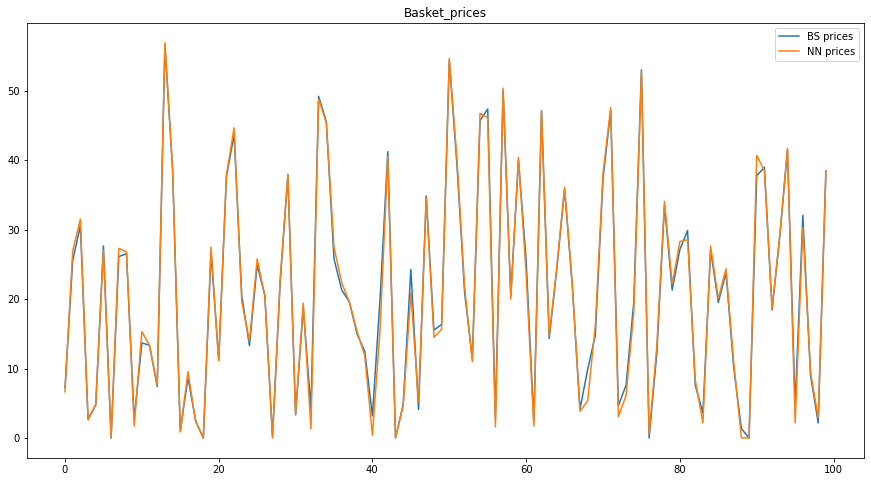

In [197]:
plt.figure(figsize=(15,8))
plt.plot(range(n), pred.reshape((y_test.shape[0],))[:n], label='BS prices')
plt.plot(range(n),y_test[:n], label='NN prices')
plt.legend()
plt.title("Basket_prices")

**Even with a simple neural network architecture, we have a good performance.**

# Compare NN performance to Monte-Carlo simulations:

We use Monte Carlo to Basket option prices.

[Monte Carlo](https://www.goddardconsulting.ca/option-pricing-monte-carlo-index.html) Pricing formula:

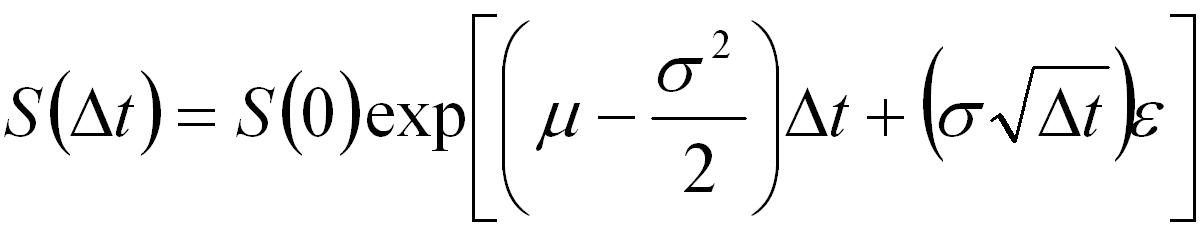

In [198]:
def MC_pricing(S_0, K, r, T, sigma, n_path=1000):
    """           
    Parameters
    ----------
    S_0: stock price at time 0
    K: strike price
    r: risk-free rate
    T: maturity date
    sigma: volatility
    n_path: number of trails of MCS
    """
    B_Ts = np.random.normal(0, T, n_path)
    S_Ts = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + sigma * B_Ts)
    payoffs = np.maximum(S_Ts - K, np.zeros(n_path)) 
    return np.exp(-1 * r * T) * np.mean(payoffs)

We use the testing set to compare the result with Neural Network predictions.

In [199]:
test = X_test.reset_index()
S_0 = test['Prices']
K = test['Strikes']
r = test['Rate']
T = test['Time_to_maturity']
sigma = test['Volatility']
  

In [200]:
%time 
start = time.time()
mc_prices = []
for i in range(test.shape[0]):
    mc_price = MC_pricing(S_0[i], K[i], r[i], T[i], sigma[i], n_path=1000)
    mc_prices.append(mc_price)
end = time.time()
print(f"Runtime of MC is : .... {end - start}")

Wall time: 0 ns
Runtime of MC is : .... 0.1629774570465088


Monte carlo prices vs Black Scholes prices for n=100 iterations:

Text(0.5, 1.0, 'Basket_prices')

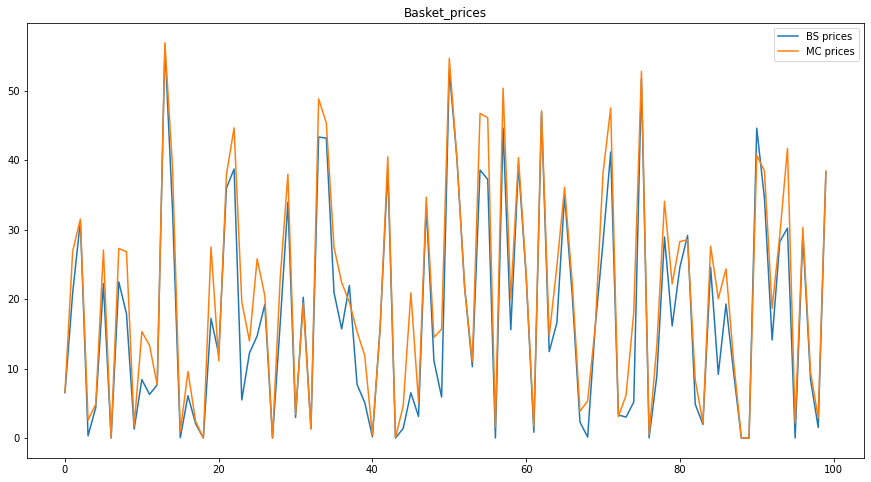

In [201]:
plt.figure(figsize=(15,8))
plt.plot(range(n), mc_prices[:n], label='BS prices')
plt.plot(range(n),y_test[:n], label='MC prices')
plt.legend()
plt.title("Basket_prices")

## Comparison:

Comparing the Neural Network prediction runtime and Monte Carlo simulation runtime, we can say that Under Black-Scholes assumptions, NN approach reduces the computing time of options pricing and has a good performance compared to Monte Carlo approach.